In [3]:
import os
import numpy as np
import torch
import time
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd import Variable
from pathlib import Path

%matplotlib inline

In [4]:
#importing the training options
os.chdir("../")
import config.train_opt as opt

In [5]:
pix2pixhd_dir = Path('./src/pix2pixHD/')

import sys
sys.path.append(str(pix2pixhd_dir))
%load_ext autoreload
%autoreload 2


In [6]:
# from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import util.util as util
from util.visualizer import Visualizer

In [7]:
opt.name = "Initial_train_images"

In [17]:
with open('./config/train_opt.pkl', mode='rb') as f:
    opt = pickle.load(f)

opt.dataroot = "./dataset"
# #Was 18 before
opt.label_nc = 0
opt.fp16 = False
opt.name="Initial_train_images"
# opt.checkpoints_dir = "./checkpoints/"

iter_path = os.path.join(opt.checkpoints_dir, opt.name, 'iter.txt')

In [8]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)
    
start_epoch, epoch_iter = 1, 0
total_steps = (start_epoch-1) * dataset_size + epoch_iter
display_delta = total_steps % opt.display_freq
print_delta = total_steps % opt.print_freq
save_delta = total_steps % opt.save_latest_freq

CustomDatasetDataLoader
dataset [AlignedDataset] was created
#training images = 26000


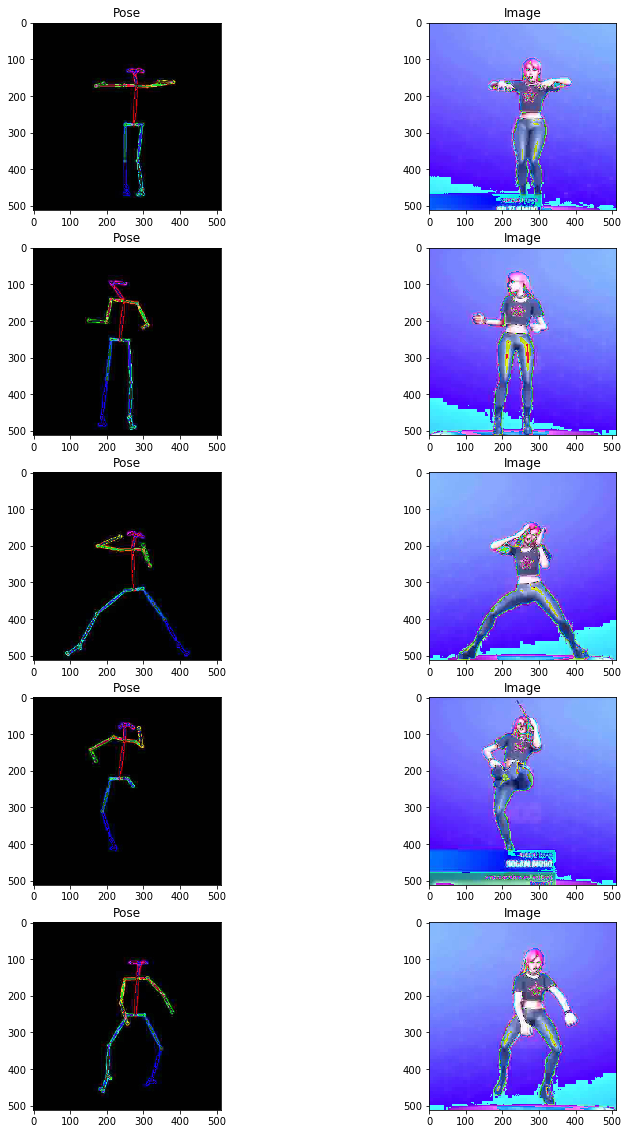

In [9]:
#For Visualization purposes
fig = plt.figure(figsize = [13,20])
for i,temp in enumerate(dataset):
    #Pose
    plt.subplot(5,2,i*2+1)
    plt.title("Pose")
    plt.imshow(temp['label'][0].permute(1,2,0))
    #Image
    plt.subplot(5,2,(i+1)*2)
    plt.title("Image")
    plt.imshow(temp['image'][0].permute(1,2,0))

    if i==4:
        break
plt.show()

In [18]:
model = create_model(opt)
visualizer = Visualizer(opt)

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affi

create web directory ./checkpoints/Initial_train_images/web...


In [20]:
for epoch in range(start_epoch, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    if epoch != start_epoch:
        epoch_iter = epoch_iter % dataset_size
    for i, data in enumerate(dataset, start=epoch_iter):
        iter_start_time = time.time()
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize

        # whether to collect output images
        save_fake = total_steps % opt.display_freq == display_delta
        
        ############## Forward Pass ######################
        losses, generated = model(Variable(data['label']), Variable(data['inst']), 
            Variable(data['image']), Variable(data['feat']), infer=True)
        
        # sum per device losses
        losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
        loss_dict = dict(zip(model.module.loss_names, losses))

        # calculate final loss scalar
        loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
        loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)
        
        ############### Backward Pass ####################
        # update generator weights
        model.module.optimizer_G.zero_grad()
        loss_G.backward()
        model.module.optimizer_G.step()

        # update discriminator weights
        model.module.optimizer_D.zero_grad()
        loss_D.backward()
        model.module.optimizer_D.step()
        
        #call(["nvidia-smi", "--format=csv", "--query-gpu=memory.used,memory.free"]) 

        ############## Display results and errors ##########
        ### print out errors
#         if total_steps % opt.print_freq == print_delta:
#             errors = {k: v.data[0] if not isinstance(v, int) else v for k, v in loss_dict.items()}
        errors = {k: v.item() if not isinstance(v, int) else v for k, v in loss_dict.items()}
        t = (time.time() - iter_start_time) / opt.batchSize
        visualizer.print_current_errors(epoch, epoch_iter, errors, t)
        visualizer.plot_current_errors(errors, total_steps)

        ### display output images
        if i%5==0:
            print(i)
            visuals = OrderedDict([('input_label', util.tensor2label(data['label'][0], opt.label_nc)),
                                   ('synthesized_image', util.tensor2im(generated.data[0])),
                                   ('real_image', util.tensor2im(data['image'][0]))])
            visualizer.display_current_results(visuals, epoch+i, total_steps)

        ### save latest model
        if total_steps % opt.save_latest_freq == save_delta:
            print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            model.module.save('latest')            
            np.savetxt(iter_path, (epoch, epoch_iter), delimiter=',', fmt='%d')

        if epoch_iter >= dataset_size:
            break
       
    # end of epoch 
    iter_end_time = time.time()
    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

    ### save model for this epoch
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_steps))        
        model.module.save('latest')
        model.module.save(epoch)
        np.savetxt(iter_path, (epoch+1, 0), delimiter=',', fmt='%d')

    ### instead of only training the local enhancer, train the entire network after certain iterations
    if (opt.niter_fix_global != 0) and (epoch == opt.niter_fix_global):
        model.module.update_fixed_params()

    ### linearly decay learning rate after certain iterations
    if epoch > opt.niter:
        model.module.update_learning_rate()
        
torch.cuda.empty_cache()

(epoch: 1, iters: 1, time: 1.525) G_GAN_Feat: 15.700 D_real: 4.131 G_GAN: 4.203 G_VGG: 7.186 D_fake: 2.581 
0
(epoch: 1, iters: 2, time: 1.528) G_GAN_Feat: 14.437 D_real: 32.213 G_GAN: 10.969 G_VGG: 6.710 D_fake: 10.478 
(epoch: 1, iters: 3, time: 1.533) G_GAN_Feat: 15.896 D_real: 3.200 G_GAN: 9.776 G_VGG: 7.238 D_fake: 9.925 
(epoch: 1, iters: 4, time: 1.531) G_GAN_Feat: 16.261 D_real: 5.739 G_GAN: 9.839 G_VGG: 7.351 D_fake: 10.134 
(epoch: 1, iters: 5, time: 1.532) G_GAN_Feat: 15.289 D_real: 2.228 G_GAN: 7.434 G_VGG: 6.689 D_fake: 7.125 
(epoch: 1, iters: 6, time: 1.522) G_GAN_Feat: 14.709 D_real: 1.717 G_GAN: 4.697 G_VGG: 6.697 D_fake: 4.325 
5
(epoch: 1, iters: 7, time: 1.514) G_GAN_Feat: 13.969 D_real: 1.486 G_GAN: 3.137 G_VGG: 6.642 D_fake: 2.483 
(epoch: 1, iters: 8, time: 1.525) G_GAN_Feat: 13.445 D_real: 0.893 G_GAN: 2.296 G_VGG: 6.167 D_fake: 1.650 
(epoch: 1, iters: 9, time: 1.521) G_GAN_Feat: 13.240 D_real: 0.885 G_GAN: 1.805 G_VGG: 6.776 D_fake: 1.033 
(epoch: 1, iters: 10

(epoch: 1, iters: 77, time: 1.511) G_GAN_Feat: 5.814 D_real: 0.598 G_GAN: 1.101 G_VGG: 4.839 D_fake: 0.374 
(epoch: 1, iters: 78, time: 1.519) G_GAN_Feat: 6.989 D_real: 0.549 G_GAN: 0.854 G_VGG: 4.910 D_fake: 0.467 
(epoch: 1, iters: 79, time: 1.514) G_GAN_Feat: 6.354 D_real: 0.414 G_GAN: 0.940 G_VGG: 4.461 D_fake: 0.444 
(epoch: 1, iters: 80, time: 1.520) G_GAN_Feat: 6.420 D_real: 0.483 G_GAN: 1.043 G_VGG: 5.502 D_fake: 0.400 
(epoch: 1, iters: 81, time: 1.519) G_GAN_Feat: 7.395 D_real: 0.498 G_GAN: 0.886 G_VGG: 5.834 D_fake: 0.597 
80
(epoch: 1, iters: 82, time: 1.504) G_GAN_Feat: 6.170 D_real: 0.627 G_GAN: 1.046 G_VGG: 4.620 D_fake: 0.536 
(epoch: 1, iters: 83, time: 1.517) G_GAN_Feat: 7.652 D_real: 0.615 G_GAN: 1.106 G_VGG: 5.109 D_fake: 0.609 
(epoch: 1, iters: 84, time: 1.515) G_GAN_Feat: 8.516 D_real: 0.664 G_GAN: 1.271 G_VGG: 5.097 D_fake: 0.382 
(epoch: 1, iters: 85, time: 1.517) G_GAN_Feat: 6.856 D_real: 0.429 G_GAN: 1.059 G_VGG: 4.658 D_fake: 0.370 
(epoch: 1, iters: 86, tim

KeyboardInterrupt: 

In [ ]:

i